Presidential Poll Analysis With Gaussian Process

By: Ryan

Main Idea:

    The main goal of this project is to predict who will be the next president of the United States. This will be done by constructing a Gaussian Process. The data being used for this model will be polling data over the last few hundred days from the pollster YouGov, that shows what percent of those polled would vote for Biden and what percent would vote for Trump. A Gaussian Process was chosen as the model for this specific problem because it does not make strong assumptions about the underlying dataset, and since we have no idea if the data here will trend in a linear fashion or in a sinusoidal one or any of the other options as we approach election day, the GP allows for flexible adaptation to any trend the data takes. The GP also creates a confidence interval as well as fitting a curve on the dataset, so this is an added benefit of the model as well, since it will show just how likely an upset victory is should confidence intervals of candidates overlap.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='whitegrid', 
    rc={'axes.facecolor': '1', 'grid.color': '.9'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100


Looking at the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
data = pd.read_csv("/Users/RyanReiff/Documents/Presidential_Poll_Data/President_Polls_2020.csv")
data.columns.values
data.head()

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
0,135481,72217,2020,Arizona,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,...,10/29/20 13:29,NaN,https://www.rasmussenreports.com/public_conten...,general,6214,Biden,13256,Joseph R. Biden Jr.,DEM,45.0
1,135481,72217,2020,Arizona,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,...,10/29/20 13:29,NaN,https://www.rasmussenreports.com/public_conten...,general,6214,Trump,13254,Donald Trump,REP,49.0
2,135521,72235,2020,Florida,1508,Harris Insights & Analytics,960,Hill.TV,Harris Poll,133.0,...,10/29/20 19:25,NaN,https://thehill.com/homenews/campaign/523477-e...,general,6220,Biden,13256,Joseph R. Biden Jr.,DEM,50.0
3,135521,72235,2020,Florida,1508,Harris Insights & Analytics,960,Hill.TV,Harris Poll,133.0,...,10/29/20 19:25,NaN,https://thehill.com/homenews/campaign/523477-e...,general,6220,Trump,13254,Donald Trump,REP,47.0
4,135522,72236,2020,North Carolina,1508,Harris Insights & Analytics,960,Hill.TV,Harris Poll,133.0,...,10/29/20 19:31,NaN,https://thehill.com/homenews/campaign/523477-e...,general,6238,Biden,13256,Joseph R. Biden Jr.,DEM,49.0


Various Pollsters and Number of Polls Conducted

In [3]:
data.pollster.value_counts()


SurveyMonkey                       4438
Morning Consult                    1016
Ipsos                               543
Emerson College                     475
Harris Insights & Analytics         426
                                   ... 
Harstad Strategic Research Inc.       2
Stockton University                   2
Rethink Priorities                    2
Clearview Research                    2
Public First                          2
Name: pollster, Length: 211, dtype: int64

Brief Analysis of Pollsters and Data Quality:

    While SurveyMonkey has the greatest number of polls, it is extremely unreliable as far as accuracy is concerned, and scores in the D- range according to FiveThirtyEight. Ipsos, as well as Morning Consult score grades in the C/B- range, which is not much better. 


Histogram that shows the Frequency of Poll Size

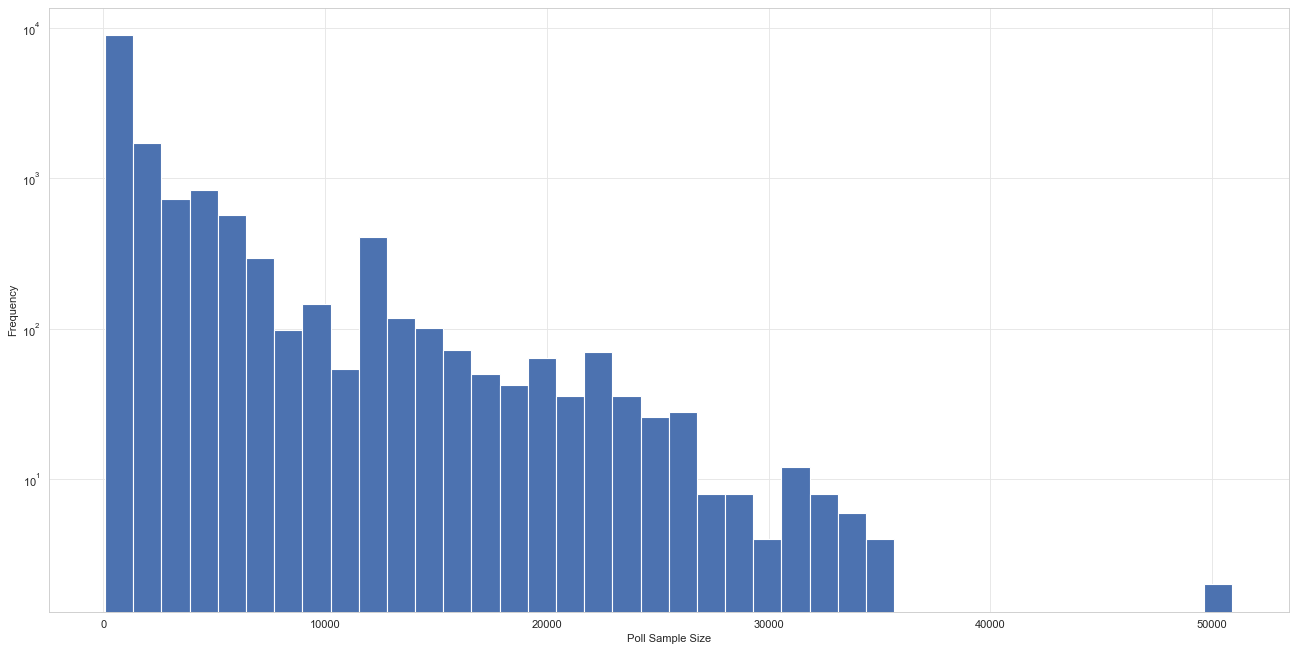

In [4]:
plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.hist(data.sample_size.dropna().values, bins=40);
plt.yscale('log');
plt.ylabel('Frequency');
plt.xlabel('Poll Sample Size');

Brief Analysis of Histogram:
    
    It can be seen from the graph above that the majority of polls consist of fewer than 30,000 participants. Usually the more people surveyed the better, since theoretically if we surveyed everyone we would indeed actually have the correct answer to the question of "Who will become president?". However, in practice there are many problems with this such as reliability of the responses of those polled, as well as the methedologies used by the pollsters. If there is a problem in the methedology in such a way that impacts accuracy, then increasing the number of people polled will usually do little to solve this problem, it will just lead to it being committed on a larger scale. For the model in this project, the size of these polls is fine.

Looking at polling frequency with respect to time until election day

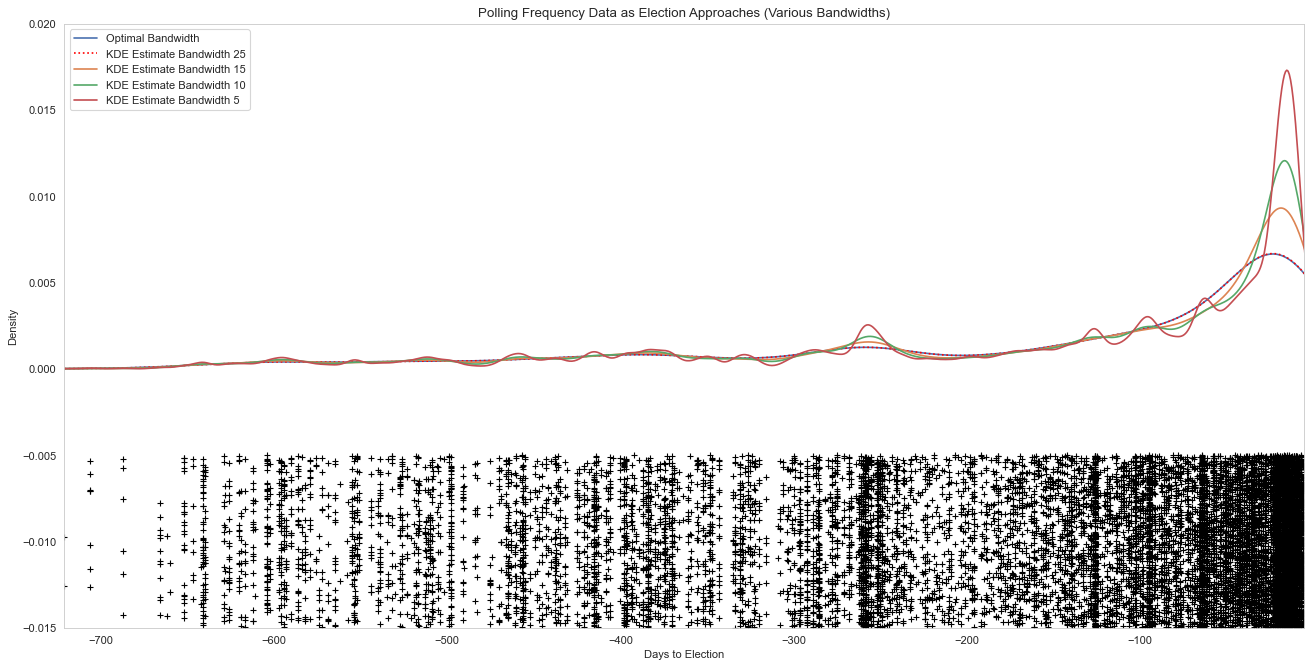

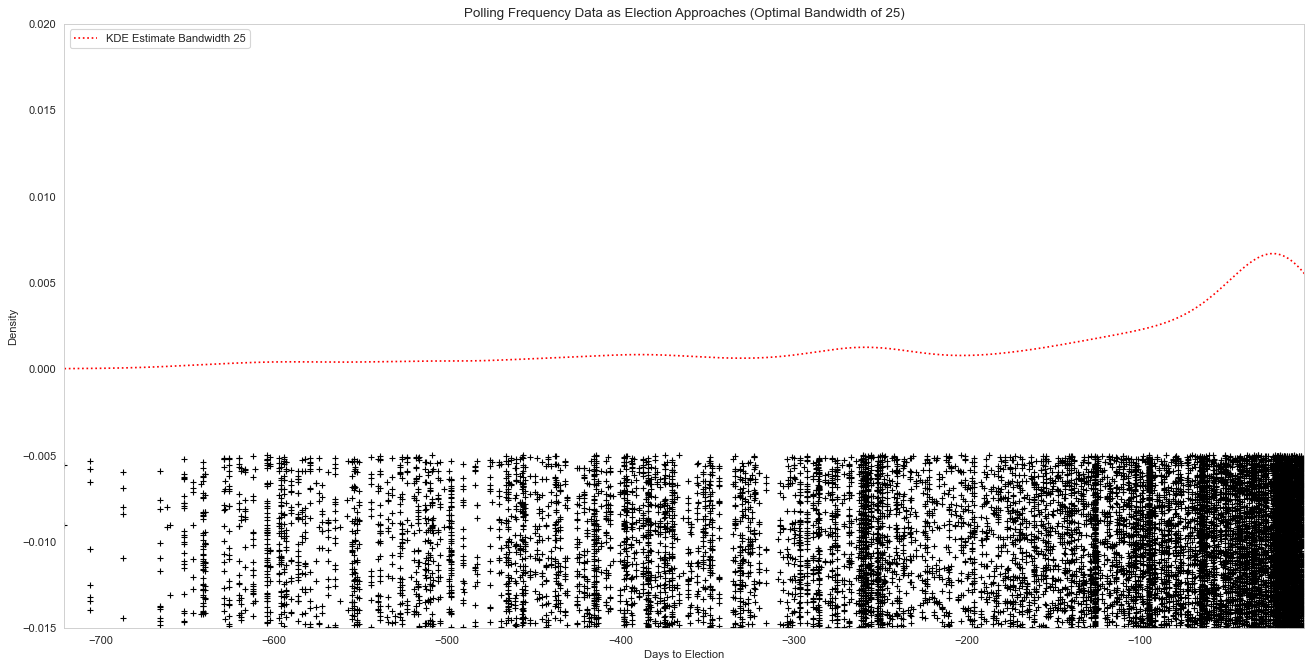

In [5]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy import stats

data['time2election'] = pd.to_datetime(data.end_date) - pd.to_datetime(data.election_date)
data['time2election'] = data['time2election']/ timedelta(1)

Now = data['time2election'][0]

national_data = data[data.state=='U.S.']
national_data = national_data[np.isfinite(national_data.sample_size)]


N = 100

X = np.atleast_2d(data.time2election).T
X_plot = np.atleast_2d(np.linspace(X.min(), 0, 1000)).T


X = X.reshape(1,-1)[0]
kde = stats.gaussian_kde(X)
kde.set_bandwidth(bw_method='scott')
yk = kde(X)


X = np.atleast_2d(data.time2election).T
kde = KernelDensity(kernel='gaussian', bandwidth=25.0).fit(X)
log_dens0 = kde.score_samples(X_plot)

kde = KernelDensity(kernel='gaussian', bandwidth=15.0).fit(X)
log_dens1 = kde.score_samples(X_plot)

kde = KernelDensity(kernel='gaussian', bandwidth=10.0).fit(X)
log_dens2 = kde.score_samples(X_plot)

kde = KernelDensity(kernel='gaussian', bandwidth=5.0).fit(X)
log_dens3 = kde.score_samples(X_plot)



plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X,yk, label = "Optimal Bandwidth")
plt.plot(X_plot[:, 0], np.exp(log_dens0), 'r:', label="KDE Estimate Bandwidth 25")
plt.plot(X_plot[:, 0], np.exp(log_dens1), '-', label="KDE Estimate Bandwidth 15")
plt.plot(X_plot[:, 0], np.exp(log_dens2), '-', label="KDE Estimate Bandwidth 10")
plt.plot(X_plot[:, 0], np.exp(log_dens3), '-', label="KDE Estimate Bandwidth 5")


plt.legend(loc='upper left')
plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

plt.title("Polling Frequency Data as Election Approaches (Various Bandwidths)")
plt.xlim(X.min(), Now)
plt.ylim(-0.015, 0.020)
plt.grid()
plt.xlabel('Days to Election')
plt.ylabel('Density')
plt.show()

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_plot[:, 0], np.exp(log_dens0), 'r:', label="KDE Estimate Bandwidth 25")
plt.legend(loc='upper left')
plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')
plt.title("Polling Frequency Data as Election Approaches (Optimal Bandwidth of 25)")
plt.xlim(X.min(), Now)
plt.ylim(-0.015, 0.020)
plt.grid()
plt.xlabel('Days to Election')
plt.ylabel('Density')
plt.show()

Analysis of Bandwidth Selection:
    
    The Kernel Density Estimate above is meant to construct a PDF for the data that shows the frequency at which polls were taken with respects to the number of days out from the election. I used the "scott" estimator to calculate the correct bandwidth (which in this case is 25), as well as a Gaussian Kernel. It can be seen from the graph above the effect that different bandwidth selections have on the KDE output, however there is no real suprise from this graph seeing as how the closer time marched towards election day, the more polls were taken.

Further Data Cleaning:

    I have elected to only use data that was gathered within the last 170 days before the election in order to construct this model. There are many reasons for this.
    1) This makes sure that there are only 2 candidates effectively left to pick from in the election. If the model included data from 300 days before the election, Biden would have much lower support since Democratic voters opinions would be split amongst the various candidates during the Primary (Butigeg, Yang, Warren, Sanders). By waiting until 170 days out, this allows supporters of neither Biden nor Trump to pick their new candidate, now that those are the only two left.
    2) The accuracy of the data is much better the closer time moves to election day. While polls go up and down because people constantly are changing their minds, if data is taken too far away from election day, it could be less reliable since people will not answer truthfully, may change their minds, don't know who they are voting for themselves, and a host of other reasons. Basically it becomes more noisy.
    3) There are simply more polls that are taken as the election draws nearer, giving more accuracy and data to work with, and creating less uncertainty in the model due to less time lapse between polls taken.

I chose to use YouGov as the pollster for this project since they have a decent rating (B grade) and they conduct a large number of polls.

In [6]:
national_data = national_data[national_data.pollster == 'YouGov']
national_data = national_data[national_data.time2election > -170]

national_data

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct,time2election
68,135152,72083,2020,U.S.,568,YouGov,352,Economist,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/nzc8dt85gn/econTab...,general,6210,Biden,13256,Joseph R. Biden Jr.,DEM,51.0,-7.0
69,135152,72083,2020,U.S.,568,YouGov,352,Economist,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/nzc8dt85gn/econTab...,general,6210,Trump,13254,Donald Trump,REP,40.0,-7.0
70,135153,72083,2020,U.S.,568,YouGov,352,Economist,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/nzc8dt85gn/econTab...,general,6210,Biden,13256,Joseph R. Biden Jr.,DEM,54.0,-7.0
71,135153,72083,2020,U.S.,568,YouGov,352,Economist,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/nzc8dt85gn/econTab...,general,6210,Trump,13254,Donald Trump,REP,43.0,-7.0
173,135491,72224,2020,U.S.,568,YouGov,278,UMass Amherst,YouGov,391.0,...,NaN,https://polsci.umass.edu/sites/default/files/P...,general,6210,Biden,13256,Joseph R. Biden Jr.,DEM,52.6,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9722,124011,66545,2020,U.S.,568,YouGov,352,Economist,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/5fsvmrvvhh/econTab...,general,6210,Trump,13254,Donald Trump,REP,42.0,-161.0
9789,123952,66514,2020,U.S.,568,YouGov,1213,Yahoo News,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/jyiylkmrh7/2020052...,general,6210,Biden,13256,Joseph R. Biden Jr.,DEM,46.0,-166.0
9790,123952,66514,2020,U.S.,568,YouGov,1213,Yahoo News,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/jyiylkmrh7/2020052...,general,6210,Trump,13254,Donald Trump,REP,42.0,-166.0
9827,123597,66380,2020,U.S.,568,YouGov,352,Economist,YouGov,391.0,...,NaN,https://docs.cdn.yougov.com/q0t43bjops/econTab...,general,6210,Biden,13256,Joseph R. Biden Jr.,DEM,47.0,-168.0


In [7]:
Biden_data = national_data[national_data.candidate_name == 'Joseph R. Biden Jr.']
Biden_data = Biden_data.groupby('time2election').mean().reset_index()

Biden_Time = Biden_data['time2election']
Biden_Time = Biden_Time.values
Biden_Pct = Biden_data['pct']
Biden_Pct = Biden_Pct.values



Trump_data = national_data[national_data.candidate_name == 'Donald Trump']
Trump_data = Trump_data.groupby('time2election').mean().reset_index()

Trump_Time = Trump_data['time2election']
Trump_Time = Trump_Time.values
Trump_Pct = Trump_data['pct']
Trump_Pct = Trump_Pct.values

Trump_data

,time2election,question_id,poll_id,cycle,pollster_id,pollster_rating_id,sample_size,seat_number,seat_name,internal,nationwide_batch,ranked_choice_reallocated,race_id,candidate_id,pct
0,-168.0,123597.00,66380.0,2020.0,568.0,391.0,1235.00,0.0,NaN,False,False,False,6210.0,13254.0,42.000
1,-166.0,123952.00,66514.0,2020.0,568.0,391.0,1218.00,0.0,NaN,False,False,False,6210.0,13254.0,42.000
2,-161.0,124011.00,66545.0,2020.0,568.0,391.0,1157.00,0.0,NaN,False,False,False,6210.0,13254.0,42.000
3,-157.0,124335.00,66670.0,2020.0,568.0,391.0,861.00,0.0,NaN,False,False,False,6210.0,13254.0,40.000
4,-155.0,124408.00,66700.0,2020.0,568.0,391.0,1486.00,0.0,NaN,False,False,False,6210.0,13254.0,43.000
5,-154.0,124450.00,66718.0,2020.0,568.0,391.0,1244.00,0.0,NaN,False,False,False,6210.0,13254.0,40.000
6,-147.0,124601.00,66779.0,2020.0,568.0,391.0,1241.00,0.0,NaN,False,False,False,6210.0,13254.0,41.000
7,-146.0,124608.00,66783.0,2020.0,568.0,391.0,1288.00,0.0,NaN,False,False,False,6210.0,13254.0,40.000
8,-140.0,124728.00,66838.0,2020.0,568.0,391.0,1160.00,0.0,NaN,False,False,False,6210.0,13254.0,41.000
9,-133.0,124874.00,66885.0,2020.0,568.0,391.0,1230.00,0.0,NaN,False,False,False,6210.0,13254.0,41.000


Analysis of Above:
    
        Since YouGov gets multiple poll results back on the same day at times, I chose to average out the results of these polls. So if 45 days out from election day, YouGov gets the results of 3 different polls that go as follows, Poll 1 Trump:45% Biden:55% , Poll 2 Trump: 47% Biden: 53% and Poll 3 Trump:40% Biden:60%, then I would turn the data at 45 days out into Trump: (45+47+40)/3 and Biden: (55+53+60)/3 so that it maps more like a function (x->y) and there are not more y-values than x-values.

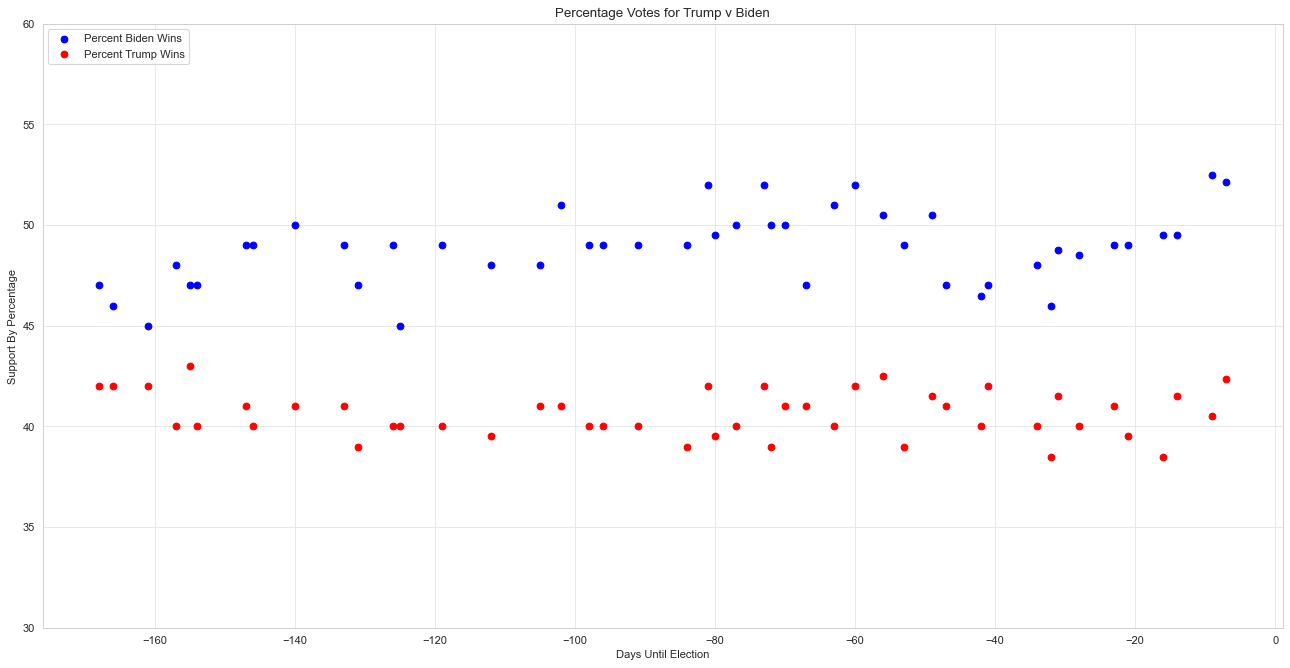

In [11]:
plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(Biden_Time, Biden_Pct, c = 'blue', label='Percent Biden Wins')
plt.ylim(30,60)
plt.title("Biden Win Probability")

plt.scatter(Trump_Time, Trump_Pct, c = 'red', label='Percent Trump Wins')
plt.ylim(30,60)
plt.title("Percentage Votes for Trump v Biden")
plt.xlabel('Days Until Election')
plt.ylabel('Support By Percentage')

plt.legend(loc='upper left')
plt.show()

Parameter Derivation:

    Once the kernel for the covariance matrix has been chosen for the Gaussian Process, the next step is to optimize the hyperparameters that are associated with the kernel. In this project, I am using a "squared exponential kernel" which is the most standard issue one out there. This kernel is also known as the "Gaussian Kernel" and programatically as an RBF kernel as seen here. When noise is involved in the data (as is assumed here) there are three parameters that must be optimized, these being "l,sigma_f,and sigma_n" from the covariance equation 
    
    K(x,x*) = sigma_f^2 * exp[(x-x*)(x-x*) * (-1/2*l^2)] + sigma_n * I
    
    Where I is the identity matrix.
    
    From this equation the Log Marginal Maximum Likelihood can be used to determine the optimal value for each hyperparameter. The maximum value of Log Marginal Likelihood can be found a variety of different ways, but basically most multivariate optimization algorithms should work. Here I have implemented the GPy library in Python in order to get the values of all of my hyperparameters.

In [9]:
import GPy

X_train = Biden_Time.reshape(-1,1)
Y_train = Biden_Pct.reshape(-1,1)

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, Y_train, rbf)

gpr.optimize()

l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])

print(gpr.Gaussian_noise.variance)
print(sigma_f)
print(l)

X_train2 = Trump_Time.reshape(-1,1)
Y_train2 = Trump_Pct.reshape(-1,1)

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr2 = GPy.models.GPRegression(X_train2, Y_train2, rbf)

gpr2.optimize()

l = gpr2.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr2.rbf.variance.values[0])

print(gpr2.Gaussian_noise.variance)
print(sigma_f)
print(l)

  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             2.94465633  |      +ve      |        
47.445896064552585
3240.7250654600057
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             1.28554471  |      +ve      |        
40.594657515598556
2902241.1756739663


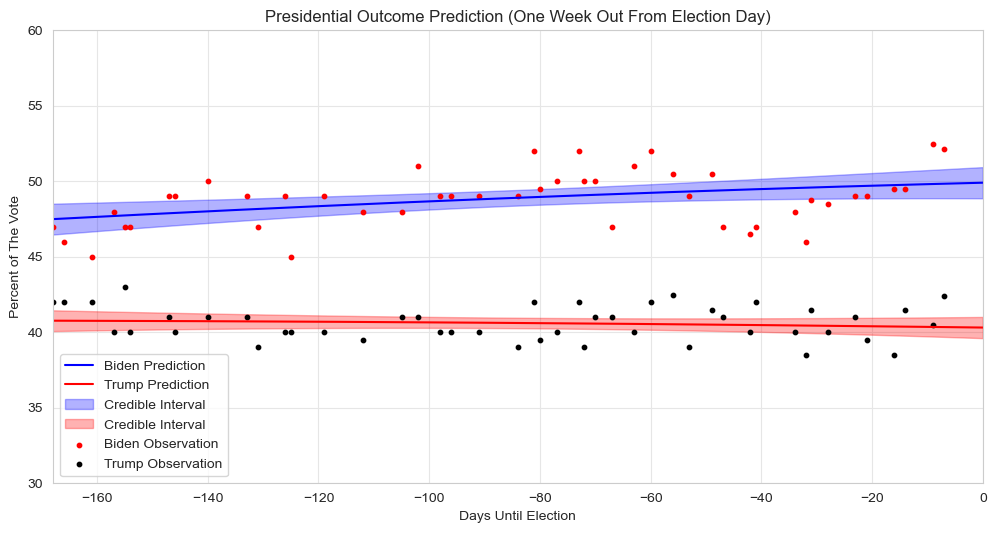

In [10]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

sigma_n_1 = 2.94465633
sigma_f_1 = 47.445896064552585
l_1 = 3240.7250654600057

n_1 = len(Biden_Time)
d = 1

n_star_1 = 500
y_1 = Biden_Pct

x_star_1 = np.linspace(start=Biden_Time[0], stop=0, num=n_star_1)
x_1 = Biden_Time

kernel = ConstantKernel(constant_value=sigma_f_1,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=l_1, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n_1, n_restarts_optimizer=0, random_state=13)
X_1 = x_1.reshape(n_1, d)
X_star_1 = x_star_1.reshape(n_star_1, d)
gp.fit(X_1, y_1)


y_pred_1,y_hat_sd_1 = gp.predict(X_star_1, return_std = True)



sigma_n_2 = 1.28554471
sigma_f_2 = 40.594657515598556
l_2 = 2902241.1756739663

n_2 = len(Trump_Time)

n_star_2 = 500
y_2 = Trump_Pct

x_star_2 = np.linspace(start=Trump_Time[0], stop=0, num=n_star_2)
x_2 = Trump_Time

kernel = ConstantKernel(constant_value=sigma_f_2,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=l_2, length_scale_bounds=(1e-3, 1e3))


gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n_2, n_restarts_optimizer=0, random_state=13)
X_2 = x_2.reshape(n_2, d)
X_star_2 = x_star_2.reshape(n_star_2, d)
gp.fit(X_2, y_2)


y_pred_2,y_hat_sd_2 = gp.predict(X_star_2, return_std = True)

fig, ax = plt.subplots()

ax.fill_between(
    x=x_star_1, 
    y1=(y_pred_1 - 2*y_hat_sd_1), 
    y2=(y_pred_1 + 2*y_hat_sd_1), 
    color='blue', 
    alpha = 0.3, 
    label='Credible Interval'
)

ax.fill_between(
    x=x_star_2, 
    y1=(y_pred_2 - 2*y_hat_sd_2), 
    y2=(y_pred_2 + 2*y_hat_sd_2), 
    color='red', 
    alpha = 0.3, 
    label='Credible Interval'
)

plt.scatter(X_1, y=y_1, s=10, c='red', label = 'Biden Observation')
sns.lineplot(x=x_star_1, y=y_pred_1, color='blue', label='Biden Prediction', ax=ax)
ax.legend(loc='upper right')


plt.scatter(X_2, y=y_2, s=10, c='black', label='Trump Observation')
sns.lineplot(x=x_star_2, y=y_pred_2, color='red', label='Trump Prediction', ax=ax)
ax.legend(loc='lower left')

plt.title("Presidential Outcome Prediction (One Week Out From Election Day)")
plt.ylim(30,60)
plt.xlim(X_2[0],0)
plt.xlabel("Days Until Election")
plt.ylabel("Percent of The Vote")
plt.show()

Project Analysis:

    From the Gaussian Curves above it looks like Biden will be the next president of the United States of America. While there was some potential for a more polynomic fit to the dataset, the Gaussain Process elected to fit roughly a line to both datasets. While one might think that we should have used a linear regression if this is the case, it is still best to use a Gaussian Process here since we do not want to make such a strong assumption about the linear relationship between time and popularity of each candidate on our dataset, and the Gaussian allows for the flexibility to fit a line or a curve since it goes where the data takes it.

Project Critiques:
    
    A model is only as good as the data that it is built on, and this project could see significant error should YouGov's polling methods be innaccurate. This would result in the fitting of a correct curve to incorrect data which means that no matter how sound the math, data cleaning, and methodologies are in this project, the results could still suffer. Another big critique in this model that the reader may have picked up on by now, is that this model only predicts who will win the popular vote (since it is built on what percent of those polled will vote for each candidate). Last election cycle in 2016 Trump lost the popular vote by a margin of millions and was still able to win the election due to the electoral college, so just because Biden is forecasted here to win the popular vote, it does not mean that America is not in for a close race a week from now.